In [ ]:
import os
from typing import Annotated, Literal, TypedDict, List, Dict, Any, Optional
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from langgraph.errors import GraphRecursionError
from langchain_core.prompts import ChatPromptTemplate


class State(TypedDict):
    """Represents the state of our graph."""
    messages: Annotated[list[AnyMessage], add_messages]
    query_attempts: int  # Track query attempts to prevent infinite loops
    final_answer: Optional[str]  # Store the final answer


class SQLAgent:
    """SQL Agent that uses LangGraph to interact with a SQLite database."""

    def __init__(
        self,
        db_path: str,
        model_name: str = "llama-3.1-8b-instant",
        groq_api_key: Optional[str] = None,
    ):
        """Initialize the SQL Agent with a SQLite database connection and Groq LLM."""
        # Create SQLite connection string
        self.connection_string = f"sqlite:///{db_path}"
        self.db = SQLDatabase.from_uri(self.connection_string)
        
        # Initialize Groq LLM
        self.llm = ChatGroq(
            model=model_name,
            api_key=groq_api_key or os.getenv("GROQ_API_KEY"),
            temperature=0,
        )

        # Setup components
        self._setup_tools()
        self._setup_prompts()
        self._build_graph()

    def _setup_tools(self) -> None:
        """Set up the required tools for database interaction."""
        toolkit = SQLDatabaseToolkit(db=self.db, llm=self.llm)
        tools = toolkit.get_tools()

        # Extract standard tools
        self.list_tables_tool = next(
            tool for tool in tools if tool.name == "sql_db_list_tables"
        )
        self.get_schema_tool = next(
            tool for tool in tools if tool.name == "sql_db_schema"
        )

        # Define the query execution tool
        @tool
        def db_query_tool(query: str) -> str:
            """Execute a SQL query against the SQLite database and get back the result."""
            try:
                result = self.db.run_no_throw(query)
                if not result:
                    return "Query executed successfully but returned no results."
                return str(result)
            except Exception as e:
                return f"Error: {str(e)}"

        self.db_query_tool = db_query_tool

    def _setup_prompts(self) -> None:
        """Set up the system prompts for query generation and checking."""
        
        self.query_gen_prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                """You are an expert SQLite database assistant. Your task is to generate SQL queries to answer user questions.

IMPORTANT RULES:
1. Generate ONLY valid SQLite SELECT queries
2. Use proper SQLite syntax (no MySQL/PostgreSQL specific functions)
3. Be careful with table and column names - use exact names from the schema
4. When in doubt about column names, use SELECT * to see all columns first
5. Use LIMIT to prevent huge result sets
6. Return ONLY the SQL query, nothing else

Example good responses:
- SELECT * FROM employees LIMIT 10;
- SELECT name, salary FROM employees WHERE department = 'IT';
- SELECT COUNT(*) FROM orders;""",
            ),
            ("placeholder", "{messages}"),
        ])

        self.interpret_prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                """You are a data analyst. Your job is to interpret SQL query results and provide clear answers.

Given the query results, provide a clear, human-readable answer that directly addresses the user's question.
Start your response with "Answer: " followed by your interpretation.

If the results are empty, explain that no matching records were found.
If there's an error, suggest what might be wrong and how to fix it.""",
            ),
            ("placeholder", "{messages}"),
        ])

    def _create_tool_node_with_fallback(self, tools: list) -> RunnableWithFallbacks:
        """Create a tool node with error handling."""
        def handle_tool_error(state: Dict) -> Dict:
            error = state.get("error")
            tool_calls = state.get("messages", [])[-1].tool_calls if state.get("messages") else []

            return {
                "messages": [
                    ToolMessage(
                        content=f"Error: {repr(error)}",
                        tool_call_id=tc["id"],
                    )
                    for tc in tool_calls
                ]
            }

        return ToolNode(tools).with_fallbacks(
            [RunnableLambda(handle_tool_error)], exception_key="error"
        )

    def _build_graph(self) -> None:
        """Build the LangGraph workflow."""
        workflow = StateGraph(State)

        def first_tool_call(state: State) -> Dict:
            """Initial node to list database tables."""
            return {
                "messages": [
                    AIMessage(
                        content="",
                        tool_calls=[
                            {
                                "name": "sql_db_list_tables",
                                "args": {},
                                "id": "tool_abcd123",
                            }
                        ],
                    )
                ],
                "query_attempts": 0,
                "final_answer": None
            }

        def model_get_schema(state: State) -> Dict:
            """Get database schema information."""
            messages = state["messages"]
            chat_with_get_schema = self.llm.bind_tools([self.get_schema_tool])
            return {"messages": [chat_with_get_schema.invoke(messages)]}

        def query_gen_node(state: State) -> Dict:
            """Generate SQL query based on user question and context."""
            messages = state["messages"]
            
            # Increment query attempts
            query_attempts = state.get("query_attempts", 0) + 1
            
            # If we've tried too many times, give up
            if query_attempts > 3:
                return {
                    "messages": [AIMessage(content="Unable to generate a working query after multiple attempts.")],
                    "query_attempts": query_attempts,
                    "final_answer": "Unable to generate a working query after multiple attempts."
                }
            
            # Generate query using the prompt
            query_response = (self.query_gen_prompt | self.llm).invoke({"messages": messages})
            
            return {
                "messages": [query_response],
                "query_attempts": query_attempts
            }

        def execute_query_node(state: State) -> Dict:
            """Execute the SQL query."""
            messages = state["messages"]
            last_message = messages[-1]
            
            # Extract SQL query from the last message
            sql_query = last_message.content.strip()
            
            # Clean up the query - look for SELECT statement
            if "SELECT" in sql_query.upper():
                lines = sql_query.split('\n')
                for line in lines:
                    if 'SELECT' in line.upper():
                        sql_query = line.strip()
                        # Remove any trailing periods or extra characters
                        if sql_query.endswith('.'):
                            sql_query = sql_query[:-1]
                        break
            
            # Execute the query
            try:
                result = self.db.run_no_throw(sql_query)
                if result is None or result == "":
                    content = "Query executed successfully but returned no results."
                else:
                    content = str(result)
                    
                return {
                    "messages": [
                        ToolMessage(
                            content=content,
                            tool_call_id="manual_query_execution"
                        )
                    ]
                }
            except Exception as e:
                return {
                    "messages": [
                        ToolMessage(
                            content=f"Error executing query: {str(e)}",
                            tool_call_id="manual_query_execution"
                        )
                    ]
                }

        def interpret_results_node(state: State) -> Dict:
            """Interpret the query results and provide final answer."""
            messages = state["messages"]
            
            # Get the interpretation
            interpretation = (self.interpret_prompt | self.llm).invoke({"messages": messages})
            
            return {
                "messages": [interpretation],
                "final_answer": interpretation.content
            }

        def should_continue_after_query_gen(state: State) -> Literal[END, "execute_query"]:
            """Determine if we should execute the query or end."""
            messages = state["messages"]
            if not messages:
                return END
                
            last_message = messages[-1]
            query_attempts = state.get("query_attempts", 0)
            
            # If we've exceeded attempts, end
            if query_attempts > 3:
                return END
            
            # If we have a valid SELECT query, execute it
            if (hasattr(last_message, 'content') and 
                last_message.content and 
                'SELECT' in last_message.content.upper()):
                return "execute_query"
            
            return END

        def should_continue_after_execution(state: State) -> Literal[END, "interpret_results", "query_gen"]:
            """Determine what to do after query execution."""
            messages = state["messages"]
            if not messages:
                return END
                
            last_message = messages[-1]
            
            # If we have an error, try generating a new query (with attempt limit)
            if (isinstance(last_message, ToolMessage) and 
                last_message.content.startswith("Error")):
                query_attempts = state.get("query_attempts", 0)
                if query_attempts >= 3:
                    return END
                return "query_gen"
            
            # If we have results, interpret them
            if isinstance(last_message, ToolMessage):
                return "interpret_results"
            
            return END

        def should_continue_after_interpretation(state: State) -> Literal[END]:
            """Always end after interpretation."""
            return END

        # Add nodes to graph
        workflow.add_node("first_tool_call", first_tool_call)
        workflow.add_node(
            "list_tables_tool",
            self._create_tool_node_with_fallback([self.list_tables_tool]),
        )
        workflow.add_node("model_get_schema", model_get_schema)
        workflow.add_node(
            "get_schema_tool",
            self._create_tool_node_with_fallback([self.get_schema_tool]),
        )
        workflow.add_node("query_gen", query_gen_node)
        workflow.add_node("execute_query", execute_query_node)
        workflow.add_node("interpret_results", interpret_results_node)

        # Add edges
        workflow.add_edge(START, "first_tool_call")
        workflow.add_edge("first_tool_call", "list_tables_tool")
        workflow.add_edge("list_tables_tool", "model_get_schema")
        workflow.add_edge("model_get_schema", "get_schema_tool")
        workflow.add_edge("get_schema_tool", "query_gen")
        
        workflow.add_conditional_edges(
            "query_gen",
            should_continue_after_query_gen,
        )
        
        workflow.add_conditional_edges(
            "execute_query",
            should_continue_after_execution,
        )
        
        workflow.add_conditional_edges(
            "interpret_results",
            should_continue_after_interpretation,
        )

        # Compile the workflow with recursion limit
        self.app = workflow.compile()

    def query(self, question: str, recursion_limit: int = 10) -> Dict[str, Any]:
        """Execute a query against the database using the agent."""
        try:
            # Invoke with recursion limit
            config = {"recursion_limit": recursion_limit}
            messages = self.app.invoke(
                {"messages": [HumanMessage(content=question)], "query_attempts": 0, "final_answer": None}, 
                config=config
            )
            
            # Extract results
            final_sql_query = self._extract_final_sql_query(messages)
            final_answer = messages.get("final_answer")
            
            if not final_answer:
                # Try to get answer from last message
                last_message = messages["messages"][-1] if messages["messages"] else None
                if last_message and hasattr(last_message, 'content'):
                    final_answer = last_message.content

            return {
                "sql_query": final_sql_query,
                "answer": final_answer
            }

        except GraphRecursionError:
            return {
                "sql_query": None,
                "answer": "Unable to process the query due to recursion limit. The query may be too complex or the database structure unclear.",
            }
        except Exception as e:
            return {
                "sql_query": None,
                "answer": f"An error occurred: {str(e)}",
            }

    def _extract_final_sql_query(self, messages: Dict) -> Optional[str]:
        """Extract the final SQL query from the message history."""
        for msg in reversed(messages.get("messages", [])):
            if hasattr(msg, "content") and msg.content:
                content = msg.content
                if 'SELECT' in content.upper():
                    # Extract the SQL query
                    lines = content.split('\n')
                    for line in lines:
                        if 'SELECT' in line.upper():
                            query = line.strip()
                            if query.endswith('.'):
                                query = query[:-1]
                            return query
        return None

    def get_table_info(self) -> str:
        """Get information about all tables in the database."""
        try:
            return self.db.get_table_info()
        except Exception as e:
            return f"Error getting table information: {str(e)}"

    def list_tables(self) -> List[str]:
        """Get list of all table names in the database."""
        try:
            return self.db.get_usable_table_names()
        except Exception as e:
            return [f"Error: {str(e)}"]


# Example usage
if __name__ == "__main__":
    # Initialize the SQL Agent with SQLite database
    agent = SQLAgent(
        db_path=r"D:\ML(ExtraClass Project)\AGENT AI\SQL-Sage-Intelligent-DB-Agent-with-Gemini-LangGraph\database\final_ecommerce.db",
        model_name="llama-3.1-8b-instant",
    )
    
    # Query the database
    print("\n=== Example Query ===")
    question = "display all users  i said all users all info about users"
    result = agent.query(question, recursion_limit=15)  # Increased limit
    
    print(f"Question: {question}")
    print(f"Generated SQL: {result['sql_query']}")
    print(f"Answer: {result['answer']}")


=== Example Query ===
Question: display all users  i said all users all info about users
Generated SQL: SELECT * FROM users LIMIT 10;
Answer: Answer: There are 6 users in the database. The users are:

1. Arun Pandey (arun@example.com)
2. Sita Sharma (sita@example.com)
3. Ram Thapa (ram@example.com)
4. Krishna Adhikari (krishna@example.com)
5. Bina Kafle (bina@example.com)
6. Binisha Chapagain (binisha@example.com)

Each user has a unique email address, phone number, and address.


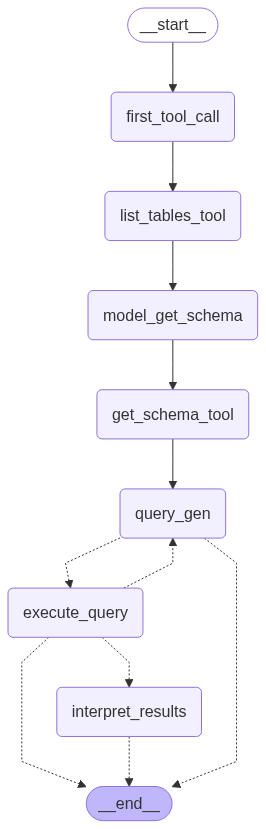

In [5]:
agent.app